# Librairies

In [39]:
# Imports
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

# Récupération du dataset

In [40]:
# dataframe
df = pd.read_csv("Documents/agribalyse-synthese.csv")
df.shape
df.head()
print(len(df))

2479


# Nettoyage des données

#### 1 - Création des constantes représentatives des colonnes

Code CIQUAL : code CIQUAL from ANSES (L’Agence nationale de sécurité sanitaire de l'alimentation, de l'environnement et du travail)

Data Quality Ratio (DQR), indique le niveau de confiance que l'on peut avoir dans le score. Plus le DQR est proche de 1, plus la donnée est fiable ; plus la valeur se rapproche de 5, plus le score rend compte d'une incertitude importante. Une donnée avec un DQR >= 3 est considérée comme peu fiable.

Initialisation des constantes pour nos noms de colonnes

In [41]:
CODE_AGB  = "Code AGB"
CODE_CIQUAL  = "Code CIQUAL"
GROUPE_ALIMENT = "Groupe d'aliment"
SOUS_GROUPE_ALIMENT = "Sous-groupe d'aliment"
LCI_NAME = "LCI Name"
NOM_PRODUIT = "Nom du Produit en Français"
LIVRAISON = "Livraison"
MATERIAU = "Matériau d'emballage"
PREPARATION = "Préparation"
DQR = "DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)"
SCORE_UNIQUE = "Score unique EF (mPt/kg de produit)"
CHANGEMENT_CLIMATIQUE = "Changement climatique (kg CO2 eq/kg de produit)"
APPAUVRISSEMENT_COUCHE_OZONE = "Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)"
RAYONNEMENTS_IONISANTS = "Rayonnements ionisants (kBq U-235 eq/kg de produit)"
FORMATION_PHOTOCHIMIQUE_OZONE = "Formation photochimique d'ozone (E-03 kg NMVOC eq/kg de produit)"
PARTICULES = "Particules (E-06 disease inc./kg de produit)"
ACIDIFICATION_TERRESTRE_EAUX_DOUCES = "Acidification terrestre et eaux douces (mol H+ eq/kg de produit)"
EUTROPHISATION_TERRESTRE = "Eutrophisation terreste (mol N eq/kg de produit)"
EUTROPHISATION_EAUX_DOUCES = "Eutrophisation eaux douces (E-03 kg P eq/kg de produit)"
EUTROPHISATION_MARINE = "Eutrophisation marine (E-03 kg N eq/kg de produit)"
UTILISATION_DU_SOL = "Utilisation du sol (Pt/kg de produit)"
ECOTOXICITE = "Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit)"
EPUISEMENT_RESSOURCES_EAU = "Épuisement des ressources eau (m3 depriv./kg de produit)"
EPUISEMENT_RESSOURCES_ENERGIE = "Épuisement des ressources énergétiques (MJ/kg de produit)"
EPUISEMENT_RESSOURCES_MINERAUX = "Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit)"
SAISON = "Saisonnalité"
TRANSPORT_AVION = "Transport par avion (1 : par avion)"

#### 2 - Suppression des colonnes non pertinantes

- **Score Unique** : Sans unité, plus le score est bas plus son impact sur l'environnement est faible. Ce score unique est une moyenne pondérée des 16 indicateurs, calculé selon la méthodologie européenne « PEF » (Product Environmental Footprint).

Dans notre cas nous possèdons uniquement de 14 indicateurs, c'est parfait pour savoir si l'on peut prédire le score avec 14/16 indicateurs nécessaires

- **Code CIQUAL** : la colonne "code CIQUAL" from ANSES (L’Agence nationale de sécurité sanitaire de l'alimentation, de l'environnement et du travail) est identique à la colonne "Code AGB" (Agribalyse) 

- **LCI name** : c'est le nom en Anglais des produits

- **Transport par avion** (1 : par avion) : Uniquement 2 produits sont concernés par cette colonne et elle ne fait pas partie des 16 indicateurs necessaires au calcul du score unique.

- **Saisonnalité** : il n’y a pas de déclinaison des indicateurs disponibles selon la saison ou l’approvisionnement en produits locaux.


- **Livraison** : ne fait pas partie des 16 indicateurs necessaires au calcul du score unique. Et pour le moment pas utilisé pour mon analyse


- **Matériau d'emballage** : ne fait pas partie des 16 indicateurs necessaires au calcul du score unique. Et pour le moment pas utilisé pour mon analyse

- **Préparation** : ne fait pas partie des 16 indicateurs necessaires au calcul du score unique. Et pour le moment pas utilisé pour mon analyse

In [42]:
# remove the 2 rows concerned by "Transport par avion"
df.drop(df[ df[TRANSPORT_AVION] == True ].index, inplace=True)

# remove the not relevant columns
df.drop(columns=[CODE_CIQUAL,
                 LCI_NAME,
                 LIVRAISON,
                 MATERIAU,
                 PREPARATION,
                 SAISON,
                 TRANSPORT_AVION
                ],
        inplace=True)

df.shape

(2477, 20)

Le Data Quality Ratio (DQR), indique le niveau de confiance que l'on peut avoir dans le score. Plus le DQR est proche de 1, plus la donnée est fiable ; plus la valeur se rapproche de 5, plus le score rend compte d'une incertitude importante. Une donnée avec un DQR >= 3 est considérée comme peu fiable.

Nous allons donc supprimer toutes les lignes dont le DQR est >= 3

In [43]:
df.drop(df[ df[DQR] >= 3 ].index, inplace=True)
lines = df.shape[0]
columns = df.shape[1]
print(f"At this step df is supposed to be cleaned and get {lines} lines and {columns} columns")

At this step df is supposed to be cleaned and get 1659 lines and 20 columns


#### 3 - On vérifie s'il nous manque des données ?

In [44]:
missing_value = columns - df.isnull().any().count()
print(f"Données manquantes = {missing_value} ")

Données manquantes = 0 


Nous avons maintenant le jeu de donnée idéale pour notre étude :

In [45]:
df.head()

Code AGB                             Groupe d'aliment Sous-groupe d'aliment  \
0    13712  fruits, légumes, légumineuses et oléagineux                fruits   
1    13713  fruits, légumes, légumineuses et oléagineux                fruits   
2    13714  fruits, légumes, légumineuses et oléagineux                fruits   
3    13715  fruits, légumes, légumineuses et oléagineux                fruits   
4    13000  fruits, légumes, légumineuses et oléagineux                fruits   

                       Nom du Produit en Français  \
0      Abricot au sirop léger, appertisé, égoutté   
1  Abricot au sirop léger, appertisé, non égoutté   
2            Abricot au sirop, appertisé, égoutté   
3        Abricot au sirop, appertisé, non égoutté   
4                         Abricot, dénoyauté, cru   

   DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)  \
0                                               2.46                   
1                                               2.46                   
2                                               2.46                   
3                                               2.44                   
4                                               2.20                   

   Score unique EF (mPt/kg de produit)  \
0                             0.215366   
1                             0.128043   
2                             0.215366   
3                             0.128043   
4                             0.118929   

   Changement climatique (kg CO2 eq/kg de produit)  \
0                                         1.221121   
1                                         0.612234   
2                                         1.221121   
3                                         0.612234   
4                                         0.861730   

   Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)  \
0                                           0.248176                       
1                                           0.153879                       
2                                           0.248176                       
3                                           0.153879                       
4                                           0.089663                       

   Rayonnements ionisants (kBq U-235 eq/kg de produit)  \
0                                           1.820853     
1                                           1.135915     
2                                           1.820853     
3                                           1.135915     
4                                           0.298539     

   Formation photochimique d'ozone (E-03 kg NMVOC eq/kg de produit)  \
0                                           4.658415                  
1                                           2.784663                  
2                                           4.658415                  
3                                           2.784663                  
4                                           3.065576                  

   Particules (E-06 disease inc./kg de produit)  \
0                                      0.096413   
1                                      0.059314   
2                                      0.096413   
3                                      0.059314   
4                                      0.061462   

   Acidification terrestre et eaux douces (mol H+ eq/kg de produit)  \
0                                           0.009301                  
1                                           0.005726                  
2                                           0.009301                  
3                                           0.005726                  
4                                           0.007254                  

   Eutrophisation terreste (mol N eq/kg de produit)  \
0                                          0.031766   
1                                          0.019499   
2                                          0.031766  

#### 4 - Stats principales pour notre **Score unique EF** (mPt/kg de produit)

In [46]:
df[SCORE_UNIQUE].describe(include = "all")

count    1659.000000
mean        0.747177
std         0.955057
min         0.006130
25%         0.180346
50%         0.430275
75%         0.859579
max         6.085768
Name: Score unique EF (mPt/kg de produit), dtype: float64

#### 5 - Visualisation de l'interval de confiance avec Seaborn

C:\Users\Hicham\AppData\Local\Temp\ipykernel_10612\2803753337.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 80)` for the same effect.

  sns.catplot(x = SCORE_UNIQUE, y = SOUS_GROUPE_ALIMENT, data = df, kind = "bar", height = 9, ci = 80)


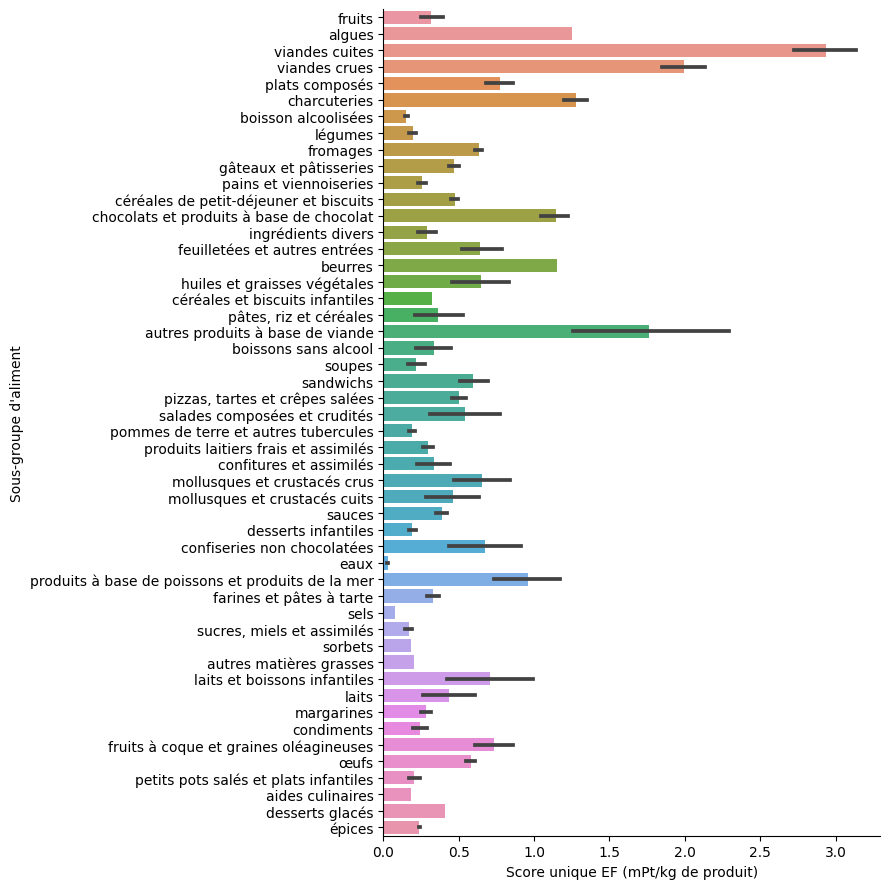

In [47]:
# Visualisation of catplot version : conversion rate with 95% confidence level
sns.catplot(x = SCORE_UNIQUE, y = SOUS_GROUPE_ALIMENT, data = df, kind = "bar", height = 9, ci = 80)

C:\Users\Hicham\AppData\Local\Temp\ipykernel_10612\832503449.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 80)` for the same effect.

  sns.catplot(x = SCORE_UNIQUE, y = GROUPE_ALIMENT, data = df, kind = "bar" , aspect = 16/9, ci = 80)


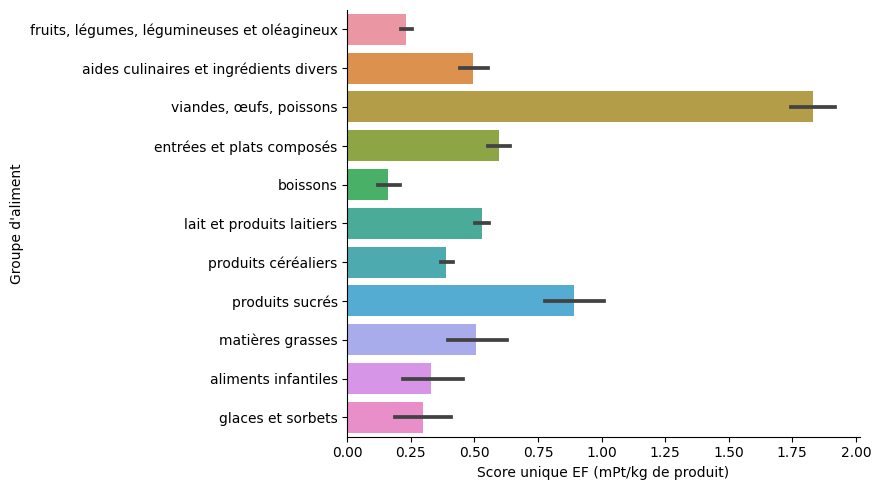

In [48]:
# Visualisation of catplot version : conversion rate with 95% confidence level
sns.catplot(x = SCORE_UNIQUE, y = GROUPE_ALIMENT, data = df, kind = "bar" , aspect = 16/9, ci = 80)

# Calcul de l'interval de confiance

In [49]:
# Calculate Mean & Standard Dev
mean = df[SCORE_UNIQUE].mean()
stdev = df[SCORE_UNIQUE].std()
n = len(df)
print(n)
    
# Set the t-value for 95% confidence interval
t = 1.28

# Compute the interval 

real_mean = [mean - t*stdev/np.sqrt(n), mean + t*stdev/np.sqrt(n)]

print(real_mean)

1659
[0.717163939498109, 0.7771908792602998]


# Prédiction de notre "Score Unique"

Pour cela nous allons utiliser le model de **Régression Lineaire Multiple**, car nous alons utiliser plusieurs variables indépendantes. (14 facteurs)

Définie par : 

$$
y = \sum_{i=0}^{n}a_{i}x_{i}
$$

## 1 - Affichage de notre Dataset

In [50]:
print(df.shape)
df.head()

(1659, 20)


Code AGB                             Groupe d'aliment Sous-groupe d'aliment  \
0    13712  fruits, légumes, légumineuses et oléagineux                fruits   
1    13713  fruits, légumes, légumineuses et oléagineux                fruits   
2    13714  fruits, légumes, légumineuses et oléagineux                fruits   
3    13715  fruits, légumes, légumineuses et oléagineux                fruits   
4    13000  fruits, légumes, légumineuses et oléagineux                fruits   

                       Nom du Produit en Français  \
0      Abricot au sirop léger, appertisé, égoutté   
1  Abricot au sirop léger, appertisé, non égoutté   
2            Abricot au sirop, appertisé, égoutté   
3        Abricot au sirop, appertisé, non égoutté   
4                         Abricot, dénoyauté, cru   

   DQR - Note de qualité de la donnée (1 excellente ; 5 très faible)  \
0                                               2.46                   
1                                               2.46                   
2                                               2.46                   
3                                               2.44                   
4                                               2.20                   

   Score unique EF (mPt/kg de produit)  \
0                             0.215366   
1                             0.128043   
2                             0.215366   
3                             0.128043   
4                             0.118929   

   Changement climatique (kg CO2 eq/kg de produit)  \
0                                         1.221121   
1                                         0.612234   
2                                         1.221121   
3                                         0.612234   
4                                         0.861730   

   Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)  \
0                                           0.248176                       
1                                           0.153879                       
2                                           0.248176                       
3                                           0.153879                       
4                                           0.089663                       

   Rayonnements ionisants (kBq U-235 eq/kg de produit)  \
0                                           1.820853     
1                                           1.135915     
2                                           1.820853     
3                                           1.135915     
4                                           0.298539     

   Formation photochimique d'ozone (E-03 kg NMVOC eq/kg de produit)  \
0                                           4.658415                  
1                                           2.784663                  
2                                           4.658415                  
3                                           2.784663                  
4                                           3.065576                  

   Particules (E-06 disease inc./kg de produit)  \
0                                      0.096413   
1                                      0.059314   
2                                      0.096413   
3                                      0.059314   
4                                      0.061462   

   Acidification terrestre et eaux douces (mol H+ eq/kg de produit)  \
0                                           0.009301                  
1                                           0.005726                  
2                                           0.009301                  
3                                           0.005726                  
4                                           0.007254                  

   Eutrophisation terreste (mol N eq/kg de produit)  \
0                                          0.031766   
1                                          0.019499   
2                                          0.031766  

## 2 - EDA 📊

<AxesSubplot: xlabel='Changement climatique (kg CO2 eq/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

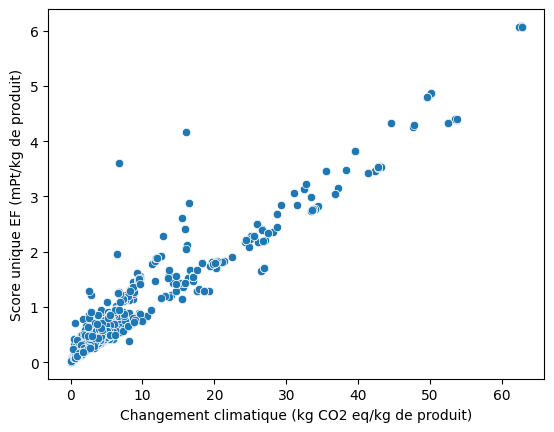

In [51]:
sns.scatterplot(
            x=CHANGEMENT_CLIMATIQUE, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel="Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)", ylabel='Score unique EF (mPt/kg de produit)'>

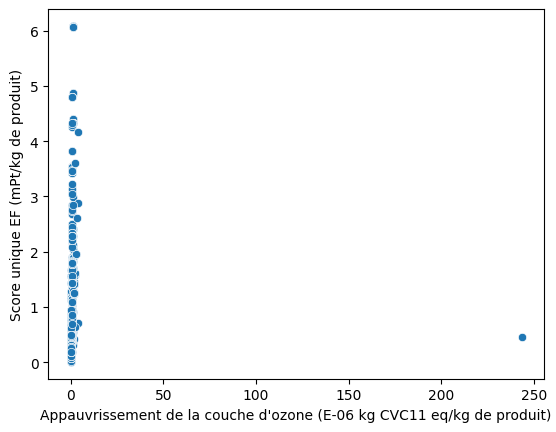

In [52]:
sns.scatterplot(
            x=APPAUVRISSEMENT_COUCHE_OZONE, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Rayonnements ionisants (kBq U-235 eq/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

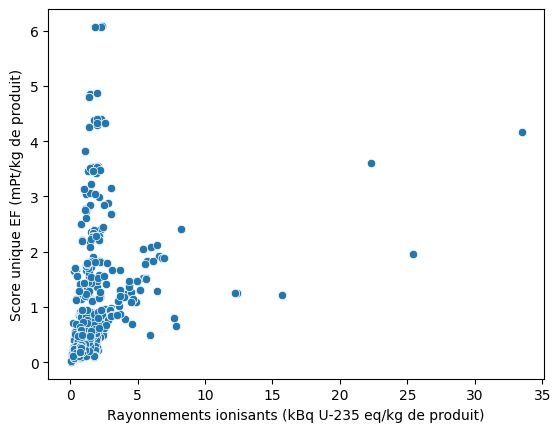

In [53]:
sns.scatterplot(
            x=RAYONNEMENTS_IONISANTS, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel="Formation photochimique d'ozone (E-03 kg NMVOC eq/kg de produit)", ylabel='Score unique EF (mPt/kg de produit)'>

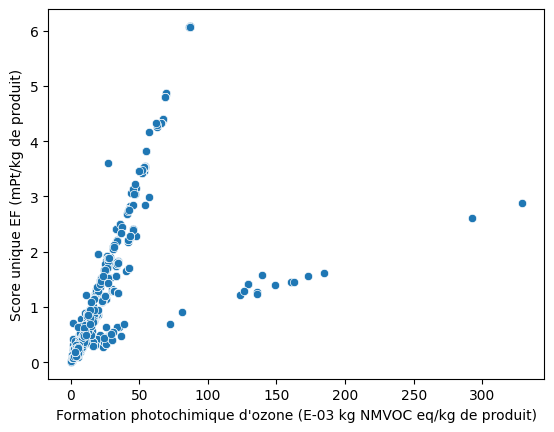

In [54]:
sns.scatterplot(
            x=FORMATION_PHOTOCHIMIQUE_OZONE, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Particules (E-06 disease inc./kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

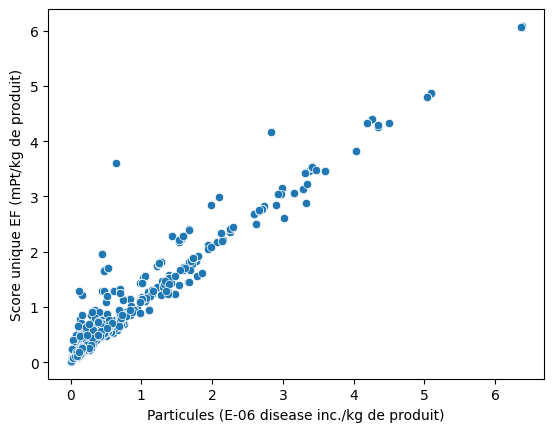

In [55]:
sns.scatterplot(
            x=PARTICULES, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Acidification terrestre et eaux douces (mol H+ eq/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

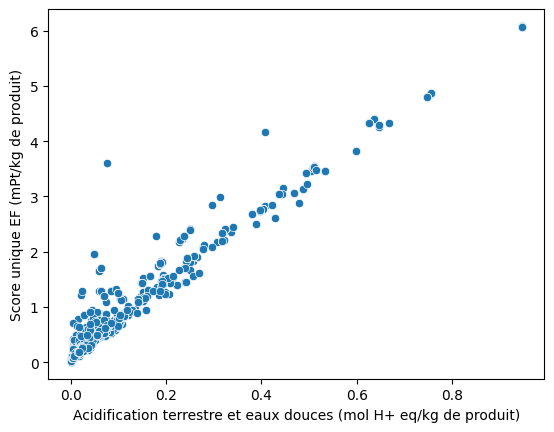

In [56]:
sns.scatterplot(
            x=ACIDIFICATION_TERRESTRE_EAUX_DOUCES, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Eutrophisation terreste (mol N eq/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

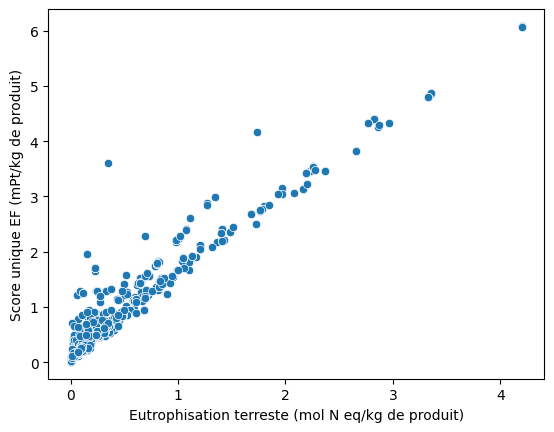

In [57]:
sns.scatterplot(
            x=EUTROPHISATION_TERRESTRE, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Eutrophisation eaux douces (E-03 kg P eq/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

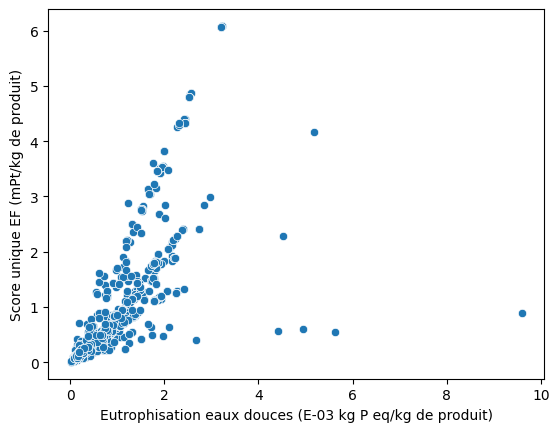

In [58]:
sns.scatterplot(
            x=EUTROPHISATION_EAUX_DOUCES, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Eutrophisation marine (E-03 kg N eq/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

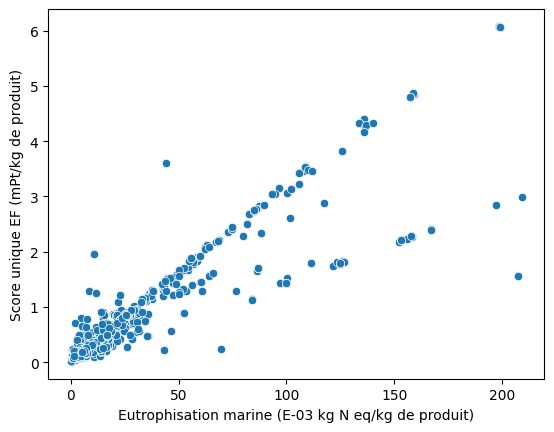

In [59]:
sns.scatterplot(
            x=EUTROPHISATION_MARINE, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Utilisation du sol (Pt/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

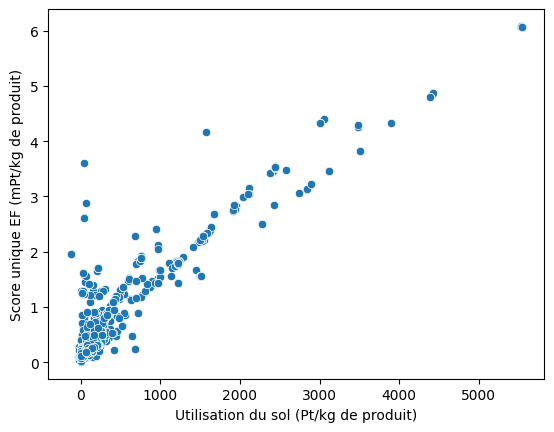

In [60]:
sns.scatterplot(
            x=UTILISATION_DU_SOL, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel="Écotoxicité pour écosystèmes aquatiques d'eau douce (CTUe/kg de produit)", ylabel='Score unique EF (mPt/kg de produit)'>

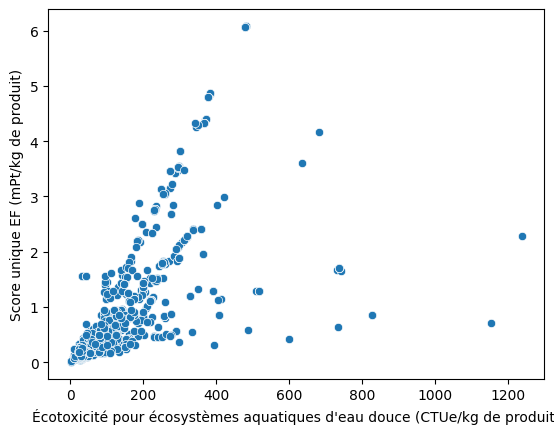

In [61]:
sns.scatterplot(
            x=ECOTOXICITE, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Épuisement des ressources eau (m3 depriv./kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

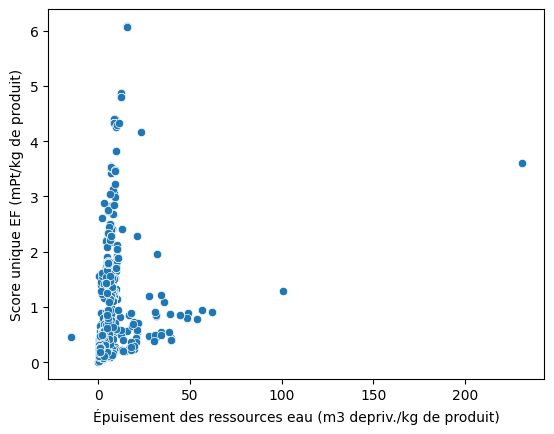

In [62]:
sns.scatterplot(
            x=EPUISEMENT_RESSOURCES_EAU, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Épuisement des ressources énergétiques (MJ/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

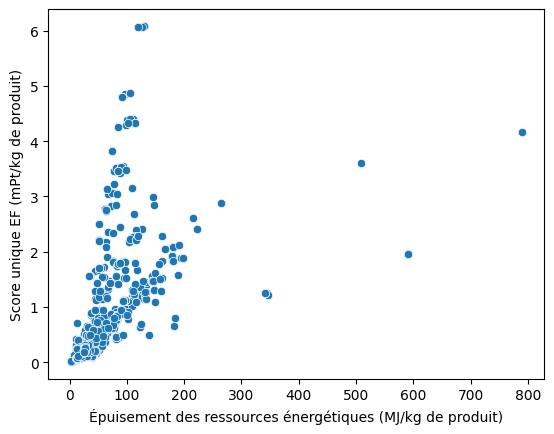

In [63]:
sns.scatterplot(
            x=EPUISEMENT_RESSOURCES_ENERGIE, 
            y=SCORE_UNIQUE, 
            data=df)

<AxesSubplot: xlabel='Épuisement des ressources minéraux (E-06 kg Sb eq/kg de produit)', ylabel='Score unique EF (mPt/kg de produit)'>

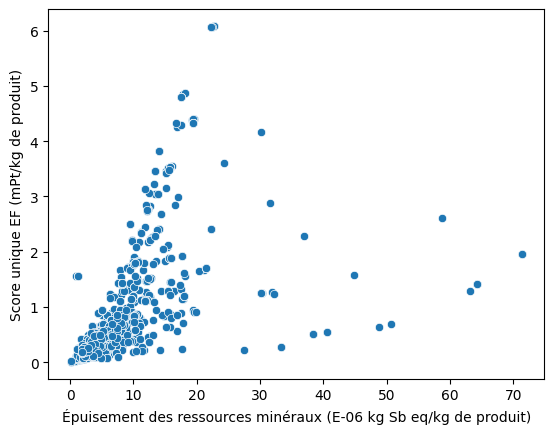

In [64]:
sns.scatterplot(
            x=EPUISEMENT_RESSOURCES_MINERAUX, 
            y=SCORE_UNIQUE, 
            data=df)

On sait qu'il ne nous manque pas de données, on peut donc passer au preprocessing.

## 3 - Preprocessing 🍳
<font color='red'>(Sans la prise en compte des groupes et sous-groupe d'aliments)</font>

- On split le dataset par $X$ et $y$

In [65]:
features_list = [
                    CHANGEMENT_CLIMATIQUE,
                    APPAUVRISSEMENT_COUCHE_OZONE,
                    RAYONNEMENTS_IONISANTS,
                    FORMATION_PHOTOCHIMIQUE_OZONE,
                    PARTICULES,
                    ACIDIFICATION_TERRESTRE_EAUX_DOUCES,
                    EUTROPHISATION_TERRESTRE,
                    EUTROPHISATION_EAUX_DOUCES,
                    EUTROPHISATION_MARINE,
                    UTILISATION_DU_SOL,
                    ECOTOXICITE,
                    EPUISEMENT_RESSOURCES_EAU,
                    EPUISEMENT_RESSOURCES_ENERGIE,
                    EPUISEMENT_RESSOURCES_MINERAUX,
                ]

X = df.loc[:,features_list]
y = df.loc[:,SCORE_UNIQUE]

print("spliting done ...")


spliting done ...


- On détermine maintenant nos X_train, Y_train, X_test, Y_test 

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=0)

print("Training Done...")   

Training Done...


- On encode nos variables de catégorie et on standardise nos valeurs numériques


In [67]:
# Encoding standardizing numeric features

numeric_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13] # Choose which column index we are going to scale
numeric_transformer = StandardScaler()

# Apply ColumnTransformer to create a pipeline that will apply the above preprocessing
feature_encoder = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
        ]
    )

X_train = feature_encoder.fit_transform(X_train)
print("...Done.")
print("#### X_train AFTER preprocessing ####")
print(X_train[0:5,:]) # print first 5 rows (not using iloc since now X_train became a numpy array)
print()

...Done.
#### X_train AFTER preprocessing ####
[[-6.29151746e-01 -8.01246218e-02 -6.21959918e-01 -6.20224067e-01
  -6.39434630e-01 -6.22002105e-01 -5.97178782e-01 -9.51214440e-01
  -7.06949376e-01 -5.13279739e-01 -9.41443434e-01 -5.09688264e-01
  -8.26454565e-01 -8.87552891e-01]
 [-3.23360351e-01 -4.42785677e-02 -2.00440509e-01 -3.21330920e-01
  -4.52569018e-01 -4.58679263e-01 -4.47614457e-01 -3.02391176e-01
  -3.60397889e-01 -3.70168224e-01 -2.30281691e-01 -8.86486762e-02
  -2.77855549e-01 -1.78525973e-03]
 [ 1.07199327e+00  2.60192652e-02 -2.91703178e-01  6.88800349e-01
   9.40360288e-03 -1.85896714e-02 -5.83521102e-02  2.00491288e+00
   7.76630411e-01 -1.67051359e-01  2.50789998e+00  5.08383933e-01
   1.84077655e-01  1.33888765e+00]
 [-5.09292988e-01 -7.49580951e-02 -5.43158711e-01 -5.32982633e-01
  -5.42819373e-01 -5.25945689e-01 -5.01632083e-01 -8.64327097e-01
  -5.98748925e-01 -4.22603425e-01 -7.91739734e-01 -4.73315553e-01
  -7.08254068e-01 -8.34587187e-01]
 [ 2.22238978e-03 -3.

### 4 - On construit le model 🏋️‍♂️

- Création et remplissage du model linéaire

In [68]:
# Train model
print("Train model...")
regressor = LinearRegression(copy_X = True)
regressor.fit(X_train, y_train) # This steps is the actual training !
print("...Done.")

Train model...
...Done.


- Prédiction sur le train set

In [69]:
# Predictions on training set
print("Predictions on training set...")
y_train_pred = regressor.predict(X_train)
print("...Done.")
print(y_train_pred[:5]) # print first 5 rows (not using iloc since now y_train became a numpy array)
print(len(y_train_pred))

Predictions on training set...
...Done.
[0.02732075 0.35389918 1.28331648 0.13746194 0.95783904]
1327


- Prédiction sur le test set

In [70]:
### Testing pipeline ###
print("--- Testing pipeline ---")

# Standardizing numeric features
print("Standardizing numerical features...")
print(X_test)
print()

X_test = feature_encoder.transform(X_test)

print("...Done.")
print(X_test[:5]) # print first 5 rows (not using iloc since now X_test became a numpy array)
print()

# Predictions on test set
print("Predictions on test set...")
y_test_pred = regressor.predict(X_test)
print("...Done.")
print(y_test_pred[:5])
print()

--- Testing pipeline ---
Standardizing numerical features...
      Changement climatique (kg CO2 eq/kg de produit)  \
1915                                         5.473532   
532                                          1.057740   
579                                          0.572184   
780                                          0.280326   
1851                                         2.282320   
...                                               ...   
1501                                         2.565563   
62                                           2.604818   
2201                                         0.645976   
1615                                         1.005751   
79                                           0.798744   

      Appauvrissement de la couche d'ozone (E-06 kg CVC11 eq/kg de produit)  \
1915                                           0.497399                       
532                                            0.127850                       
579              

- score de notre model sur les train et test sets

Dans notre cas nous avons beaucoup de variables indépendantes (feature_list) donc il est plus judicieux d'utiliser le "adjusted R squared" 

Si nous utilisons le "R squared" il y a de forte chance de trouver un score très proche de 1.

- R Squared Évaluation

$$
R^{2} = 1 - \frac{\sum_{i=1}^{n}(y_{i}-\hat{y_{i}})^{2}}{\sum_{i=1}^{n}(y_{i}-\bar{y_{i}})^{2}}
$$

In [71]:
# Performance assessment
print("--- Assessing the performances of the model ---")
r2_train = regressor.score(X_train, y_train)
r2_test = regressor.score(X_test, y_test)
# Print R^2 scores
print(f"R2 score on training set : {r2_train}" )
print(f"R2 score on test set : {r2_test}", )

--- Assessing the performances of the model ---
R2 score on training set : 0.9999857424172217
R2 score on test set : 0.9999884157289006


Comme prévu nous avons un score presque égale à 1 avec la méthode du "R Squared"

- Adjusted R Squared Évaluation

$$
adj R^{2} = 1-(1-R^{2})\frac{n-1}{n-p-1}
$$

In [72]:
# Performance assessment
print("--- Assessing the performances of the model ---")

# adjusted R-squared
Adj_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)
Adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

# Print Adjusted R^2 scores
print("Adjusted R2 score on training set : ", Adj_r2_train)
print("Adjusted R2 score on test set : ", Adj_r2_test)


--- Assessing the performances of the model ---
Adjusted R2 score on training set :  0.9999855902783811
Adjusted R2 score on test set :  0.9999879041207133


In [73]:
print(f"diff adj_r2_train et r2_train : {(r2_train - Adj_r2_train)}")
print(f"diff adj_r2_test et r2_test : {(r2_test - Adj_r2_test)}")

diff adj_r2_train et r2_train : 1.5213884063669525e-07
diff adj_r2_test et r2_test : 5.116081873701717e-07


- Calcul des coefficients


In [74]:
print("coefficients are: ", regressor.coef_) 
print("Constant is: ", regressor.intercept_)
X_train[:5] # Visualize the first 5 rows of your X_train


coefficients are:  [0.26663755 0.00797069 0.01452256 0.02546964 0.1945836  0.05715267
 0.1713172  0.01287876 0.06332602 0.0580741  0.05280848 0.06673406
 0.08468198 0.01014081]
Constant is:  0.7323668753595328


array([[-6.29151746e-01, -8.01246218e-02, -6.21959918e-01,
        -6.20224067e-01, -6.39434630e-01, -6.22002105e-01,
        -5.97178782e-01, -9.51214440e-01, -7.06949376e-01,
        -5.13279739e-01, -9.41443434e-01, -5.09688264e-01,
        -8.26454565e-01, -8.87552891e-01],
       [-3.23360351e-01, -4.42785677e-02, -2.00440509e-01,
        -3.21330920e-01, -4.52569018e-01, -4.58679263e-01,
        -4.47614457e-01, -3.02391176e-01, -3.60397889e-01,
        -3.70168224e-01, -2.30281691e-01, -8.86486762e-02,
        -2.77855549e-01, -1.78525973e-03],
       [ 1.07199327e+00,  2.60192652e-02, -2.91703178e-01,
         6.88800349e-01,  9.40360288e-03, -1.85896714e-02,
        -5.83521102e-02,  2.00491288e+00,  7.76630411e-01,
        -1.67051359e-01,  2.50789998e+00,  5.08383933e-01,
         1.84077655e-01,  1.33888765e+00],
       [-5.09292988e-01, -7.49580951e-02, -5.43158711e-01,
        -5.32982633e-01, -5.42819373e-01, -5.25945689e-01,
        -5.01632083e-01, -8.64327097e-01, -5.

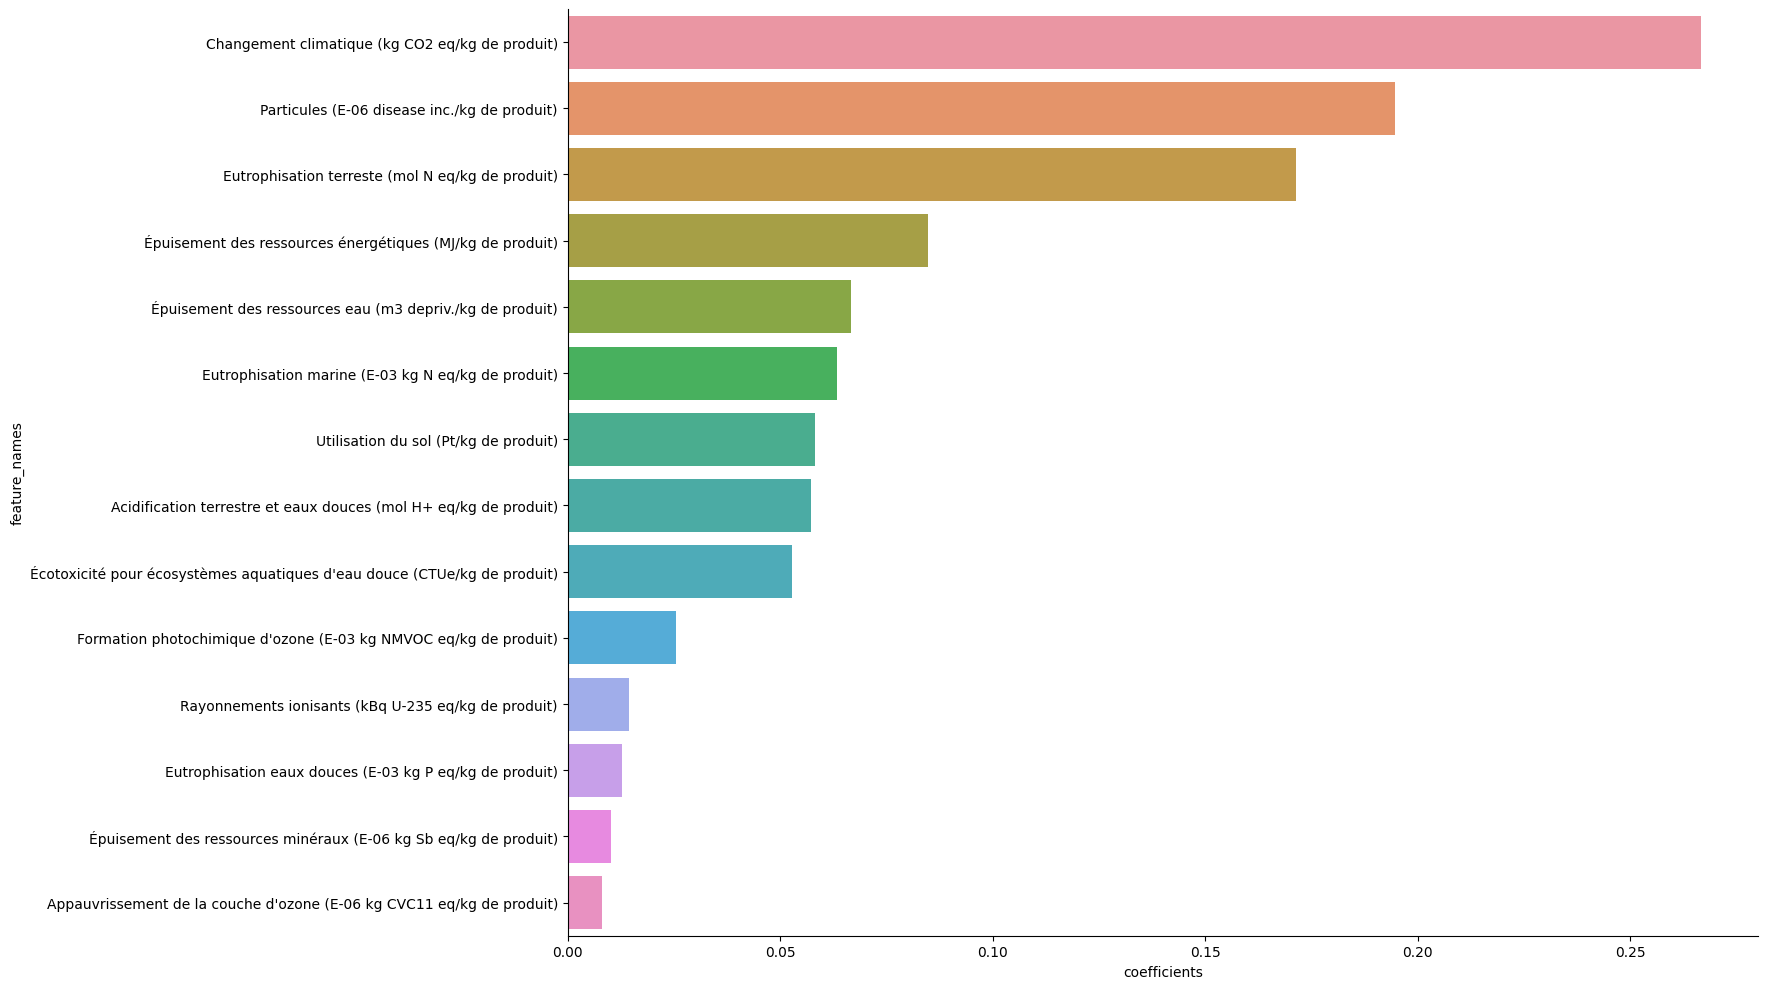

In [75]:
numerical_column_names = X.iloc[:, numeric_features].columns # using the .columns attribute gives us the name of the column 
# Feature importance 
feature_importance = pd.DataFrame({
    "feature_names": numerical_column_names,
    "coefficients":regressor.coef_
})

# Set coefficient to absolute values to rank features
feature_importance["coefficients"] = feature_importance["coefficients"].abs()

# Visualize ranked features using seaborn
sns.catplot(x="coefficients", 
            y="feature_names", 
            data=feature_importance.sort_values(by="coefficients", ascending=False), 
            kind="bar",
            height = 10,
            aspect=16/9) # Resize graph

In [83]:
feature_importance.sort_values(by="coefficients", ascending = False)

feature_names  coefficients
0     Changement climatique (kg CO2 eq/kg de produit)      0.266638
4        Particules (E-06 disease inc./kg de produit)      0.194584
6    Eutrophisation terreste (mol N eq/kg de produit)      0.171317
12  Épuisement des ressources énergétiques (MJ/kg ...      0.084682
11  Épuisement des ressources eau (m3 depriv./kg d...      0.066734
8   Eutrophisation marine (E-03 kg N eq/kg de prod...      0.063326
9               Utilisation du sol (Pt/kg de produit)      0.058074
5   Acidification terrestre et eaux douces (mol H+...      0.057153
10  Écotoxicité pour écosystèmes aquatiques d'eau ...      0.052808
3   Formation photochimique d'ozone (E-03 kg NMVOC...      0.025470
2   Rayonnements ionisants (kBq U-235 eq/kg de pro...      0.014523
7   Eutrophisation eaux douces (E-03 kg P eq/kg de...      0.012879
13  Épuisement des ressources minéraux (E-06 kg Sb...      0.010141
1   Appauvrissement de la couche d'ozone (E-06 kg ...      0.007971